<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_Image_Segmentation_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP LEARNING COMPUTER VISION : Image Segmentation Keras

In this notebook, I implement the common execution (with my own explanations) of the Image Segmentation Keras tool. This is a tool to semantic segmentation.

Semantic segmentation is the task of classifying each pixel in an image from a predefined set of classes. 

For more info about the tool and its use you can access to [the tutorial in the author's blog](https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html). In this tutorial you have a very datailed explanation of the theory about this Deep Learning Tool (this theory is not in this notebook).

GITHUB: https://github.com/divamgupta/image-segmentation-keras


## INSTALLATION


* This tool can be installed:

```
 $> pip install keras-segmentation
```

or

```
 $> pip install --upgrade git+https://github.com/divamgupta/image-segmentation-keras
```

The default pip dataset package version (`pip install keras-segmentation`) has problems with the *evaluation* method. 
They recommend install by github ([explanation link](https://github.com/divamgupta/image-segmentation-keras/issues/165)):

In [0]:
pip install --upgrade git+https://github.com/divamgupta/image-segmentation-keras

* We need keras version 2

In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

* Opencv

In [0]:
!pip install opencv-python

* Theano / Tensorflow / CNTK

In [0]:
! apt-get install -y libsm6 libxext6 libxrender-dev

## DATASET

### Explanation

Keras segmentation needs the input RGB images and the corresponding segmentation images. 

Assign each class a unique ID. In the segmentation images, the pixel value should denote the class ID of the corresponding pixel. This is a common format used by most of the datasets and keras_segmentation. For the segmentation maps, do not use the jpg format as jpg is lossy and the pixel values might change. Use bmp or png format instead. And of course, the size of the input image and the segmentation image should be the same.

![segment image](https://divamgupta.com/assets/images/posts/imgseg/image14.png?style=centerme)

After generating the segmentation images, place them in the training/testing folder. Make separate folders for input images and the segmentation images. The file name of the input image and the corresponding segmentation image should be the same.

Refer to the format below :

```
dataset/
	train_images/
		- img0001.png
		- img0002.png
		- img0003.png
	train_segmentation/
		- img0001.png
		- img0002.png
		- img0003.png
	val_images/
		- img0004.png
		- img0005.png
		- img0006.png
	val_segmentation/
		- img0004.png
		- img0005.png
		- img0006.png
```




In this notebook, I am going to use as dataset the provided by the tool to tests: https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJhWVJMNEU/view?usp=sharing

But you can generate your own dataset. There are some tools you can use to manually annotate and segment the images, such as, [LABELME](https://github.com/wkentaro/labelme) or GIMP. 

In my case, I use this tool in an internal [DataSpartan](https://dataspartan.co.uk/) project ([restricted link](https://gitlab.dataspartan.com/dataspartan/ai-documents/ai-documents-page-segmentation)). We wanted to annotate the segments or parts of documents (ex., header, footer, text, title, table, figure, ...). Our process was:
1. We converted documents from pdf to png
2. We used the prodigy tool to annotate this png images ([computer vision in prodigy](https://prodi.gy/features/computer-vision)). [Video about the annotation protocol in this project.](https://drive.google.com/file/d/1TGr65c5VJO0dPYczquHm4uBdVP2VvdPc/view?usp=sharing).
3. Prodigy store the vertix of each annotated segment: (x0, y0), (x1, y1), (x2, y2) and (x3, y3). We generate programatically the segment file with a code like:

```
import cv2
import numpy as np

ann_img = np.zeros((img_height,img_width,3)).astype('uint8')

for (x0,y0,x1,y1,x2,y2,x3,y3,label_id) in prodigy_annotations:
  ann_img[ x0:x3, y0:y3 ] = label_id # this would set the label of the set of annotated segment pixels as the appropriate numeric value

cv2.imwrite( "ann_1.png" ,ann_img )
```

In any case, this process isn't the goal of this notebook.



### Download the dataset

We are going to use in this notebook the basic test dataset. : https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJhWVJMNEU/view?usp=sharing

This dataset zip is provided via google drive. We need install in colab a tool to be able of download files from drive: [gdown](https://kobkrit.com/how-to-directly-download-files-from-dropbox-or-google-drive-using-wget-in-terminal-or-in-google-573168195011)

In [0]:
!pip install gdown

In [0]:
!gdown --id 0B0d9ZiqAgFkiOHR1NTJhWVJMNEU

Downloading...
From: https://drive.google.com/uc?id=0B0d9ZiqAgFkiOHR1NTJhWVJMNEU
To: /content/dataset1.zip
126MB [00:00, 204MB/s]


In [0]:
!unzip dataset1.zip

### Validate the dataset

Now, we have in the local filesystem a folder ```dataset1```

In [0]:
!ls

dataset1  dataset1.zip	sample_data


In this folder, we have 4 subfolders, as we explain before: images_to_train, annotations_to_train, images_to_test, & annotations_to_test

In [0]:
!ls dataset1

annotations_prepped_test   images_prepped_test
annotations_prepped_train  images_prepped_train


The number of images and segments to train (or test) HAVE to be the same.

In [0]:
from os import listdir
from os.path import isfile, join
images_train = [f for f in listdir("dataset1/images_prepped_train") if isfile(join("dataset1/images_prepped_train", f))]
segment_train = [f for f in listdir("dataset1/annotations_prepped_train") if isfile(join("dataset1/annotations_prepped_train", f))]
images_test = [f for f in listdir("dataset1/images_prepped_test") if isfile(join("dataset1/images_prepped_test", f))]
segment_test = [f for f in listdir("dataset1/annotations_prepped_test") if isfile(join("dataset1/annotations_prepped_test", f))]

In [0]:
print(f'Number of images to train: {len(images_train)}')
print(f'Number of segments to train: {len(segment_train)}')
assert len(images_train)==len(segment_train), "Number of segments and images to train are different"

print(f'Number of images to test: {len(images_test)}')
print(f'Number of images to test: {len(segment_test)}')
assert len(images_test)==len(segment_test), "Number of segments and images to test are different"

Number of images to train: 367
Number of segments to train: 367
Number of images to test: 101
Number of images to test: 101


Each image HAVE to have a corresponding segment file.

In [0]:
import collections
#Check if two list have exactly the same values
collections.Counter(images_train) == collections.Counter(segment_train)
collections.Counter(images_test) == collections.Counter(segment_test)

True

Furthermore, the dimensions of each image-segment pair HAVE to be equal!

In [0]:
from PIL import Image
for img_filename in images_train:
  img = Image.open("dataset1/images_prepped_train/"+img_filename)
  seg = Image.open("dataset1/annotations_prepped_train/"+img_filename)
  assert img.size == seg.size, f"The train pair '{img_filename}' haven't different dimensions : {img.size} - {seg.size}"

for img_filename in images_test:
  img = Image.open("dataset1/images_prepped_test/"+img_filename)
  seg = Image.open("dataset1/annotations_prepped_test/"+img_filename)
  assert img.size == seg.size, f"The test pair '{img_filename}' haven't different dimensions : {img.size} - {seg.size}"

Perfect, our dataset is correct, and it can be used in the image segmentation keras tool!

**Note**: This validation process was to explain the structure of the dataset. You don't have to validate manually your own dataset. The `image segmentation keras` tool has its own dataset validator.

### Visualize the dataset

Now we are going to show some instructions (and tips) to visualize the images.

First of all, we select the image-segmentation pair to visualize.

In [0]:
import cv2

it_visualize = 10

img = cv2.imread("dataset1/images_prepped_train/"+images_train[it_visualize])
seg = cv2.imread("dataset1/annotations_prepped_train/"+images_train[it_visualize])

Visualize the original image

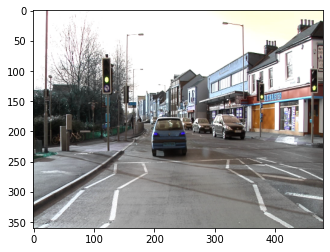

In [0]:
import matplotlib.pyplot as plt
plt.imshow(img.astype('uint8'))

Visualize the segmentation file. 

The problem here is the labels (0,1,2, ...) are consecutive, that means in RGB terms, the image has segment with pixels: 0,0,0 ; 1,1,1 ; 2,2,2 ; ... For the human eye, these variations are not easily perceived.

The trick is use only one channel of the RGB, because `matplotlib` automatically plot human-friendly visualization of this arrays.

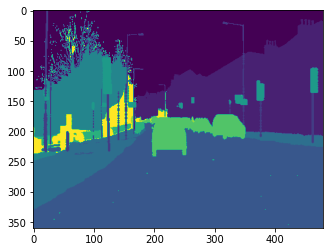

In [0]:
import matplotlib.pyplot as plt
b, g, r    = cv2.split(seg)  #If we use only the file the plt is practically all black (similar rgb percetion of 0,0,0 ; 1,1,1 ; 2,2,2 ...)
plt.imshow(b)

Visualize a combination of image-segmentation pair.

We have the same problem of the previous visualization (human perception). 

My trick, get the RGB channels of the segmentation file individually and multiply them by different modifiers previously to the fusion with the image.

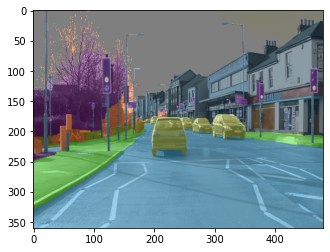

In [0]:
import numpy as np

#Split channels and modify each of them by some modifier
b, g, r    = cv2.split(seg) 
altered_seg = np.dstack((r*21,g*56,b*74))

from keras_segmentation.predict import overlay_seg_image
fused_img = overlay_seg_image(img, altered_seg)

import matplotlib.pyplot as plt
plt.imshow(fused_img.astype('uint8'))

### Last notes about dataset

This basic dataset doesn't have info about what is each label. I recommend, if you generate manually your annotations, having a dictionary with the conversion: `label_name - label_id`. For example:
```
{
  0 : "background",
  1 : "person",
  2 : "road",
  3 : "tree",
  ...
}  
```

That is gonna to make you easier the process of depuration and visualization.

Another important point is, as we'll see later, the dimensions of the input files. Does all of them have to have the same dimensions? Not necessarily. The `image segmentation keras` tool makes internally the adaptation (or resized) of each image to a fixed dimension (the dimensions defined in the model).     

In any case, be aware that if the input dimensions are very different (or with a very different aspect ratio) it could affect your result. Furthermore, you would need to resize the model prediction output to adapt it to your original input. 

Issue in the github: [link](https://github.com/divamgupta/image-segmentation-keras/issues/144)


## MODEL DEFINITION

The `image segmentation keras` tool support a significant variety of Computer Vision models. You can see the list in the [github](https://github.com/divamgupta/image-segmentation-keras) or you can list them with the instruction:

In [0]:
from keras_segmentation.models.all_models import model_from_name

model_names = list(model_from_name.keys())
print(f'Model names : {model_names}')

Model names : ['fcn_8', 'fcn_32', 'fcn_8_vgg', 'fcn_32_vgg', 'fcn_8_resnet50', 'fcn_32_resnet50', 'fcn_8_mobilenet', 'fcn_32_mobilenet', 'pspnet', 'vgg_pspnet', 'resnet50_pspnet', 'pspnet_50', 'pspnet_101', 'unet_mini', 'unet', 'vgg_unet', 'resnet50_unet', 'mobilenet_unet', 'segnet', 'vgg_segnet', 'resnet50_segnet', 'mobilenet_segnet']


You can train one of this models from raw or fine-tuning a pretrained one.

### Raw

When you train a model from raw, you need to select a height and width to the model definition. This height and width should be the height and width of the expected input images (and the output). 

It doesn't mean that all your input images have to have this dimension. Because the `image segmentation keras` tool adapt (or resized) each input file to the dimension defined in the model. But it is important that this adaptation (or resized) doesn´t make you lost info (ex., a bus in a long panoramic image is very different if you then adapt the image to a square dimension).

Thus, you need that your dataset input files have a similar dimension or (relation aspect). I recommend that you filter the input files that have a very different aspect. For example, in the DataSpartan project, we filtered those pages that were not similar to a vertical A4 format.

In conclusion, we need a representative height and width of the complete collection of the dataset. In this notebook, this process is very easy because all the input images have the same dimension.

In [0]:
from PIL import Image

height = 0
width = 0
for img_filename in images_train:
  img = Image.open("dataset1/images_prepped_train/"+img_filename)
  if width < img.size[0]:
    width = img.size[0]
  if height < img.size[1]:
    height = img.size[1]

print(f'The max size of our input files is: ({height},{width})')

The max size of our input files is: (360,480)


In any case, the model can need you define an input height and width in basis a some factor (ex., 32 or 192). In my code, I am going to write a general function, but you should adapt your dimension directly to your selected model. For example:

```
from keras_segmentation.models.unet import vgg_unet

model = vgg_unet(n_classes=51 ,  input_height=416, input_width=608  )
```

In [0]:
from keras_segmentation.models.all_models import model_from_name
import math

def define_model_from_name(model_name, n_classes, height, width):
  common_factors = [1, 32, 192]
  for common_factor in common_factors:
    try:
        input_height = common_factor * math.ceil( height/common_factor )
        input_width  = common_factor * math.ceil( width/common_factor )

        model = model_from_name[ model_name ](
            n_classes= n_classes ,
            input_height=input_height,
            input_width=input_width  )
        
        return model
    except: 
      print("Problem with the currenct factor")        

Now we generate the basic model. 
 - 51 is the number of classes in the given dataset (in your dataset you should change it). 

In [0]:
raw_model = define_model_from_name('fcn_8', 51, height, width)

### Fine-tuning

The `image segmentation keras` tool includes a list of pretrained models. You can review:
 - [Github readme](https://github.com/divamgupta/image-segmentation-keras#pre-trained-models)
 - [Class definition with the list and metadata of each pretrained model](https://github.com/divamgupta/image-segmentation-keras/blob/master/keras_segmentation/pretrained.py)

These pre-trained models adapt a basic model (pspnet, resnet, ...) with a fixed height and width.

In [0]:
from keras_segmentation.pretrained import pspnet_50_ADE_20K , pspnet_101_cityscapes, pspnet_101_voc12, resnet_pspnet_VOC12_v0_1

model_pspnet_50_ADE_20K        = pspnet_50_ADE_20K() # load the pretrained model trained on ADE20k dataset

model_pspnet_101_cityscapes    = pspnet_101_cityscapes() # load the pretrained model trained on Cityscapes dataset

model_pspnet_101_voc12         = pspnet_101_voc12() # load the pretrained model trained on Pascal VOC 2012 dataset

model_resnet_pspnet_VOC12_v0_1 = resnet_pspnet_VOC12_v0_1() # load the pretrained model trained on Pascal VOC 2012 dataset

94658560/94653016 [==============================] - 8s 0us/step


You can use them to fine-tuning your own model ([github link](https://github.com/divamgupta/image-segmentation-keras#fine-tuning-from-existing-segmentation-model)).

You only can transfer the weights to the same basic model.

In [0]:
from keras_segmentation.models.model_utils import transfer_weights
from keras_segmentation.pretrained import pspnet_50_ADE_20K
from keras_segmentation.models.pspnet import pspnet_50

pretrained_model = pspnet_50_ADE_20K()

finetuning_model = pspnet_50( n_classes=51 )

transfer_weights( pretrained_model , finetuning_model  ) # transfer weights from pre-trained model to your model

62it [00:00, 610.13it/s]

Copying weights 


225it [00:00, 377.99it/s]

Copied weights of 120 layers and skipped 1 layers


## TRAINING

Be aware: the training process can take some time to complete. It is probably a problem in services like `Google Colab` because it can close your connexion before this process finish. 

When you train (or fine-tuning) the tool store the model weights and description in a folder. You should indicate this folder.

In [0]:
checkpoint_folder = "keras_checkpoint"

In [0]:
!mkdir {checkpoint_folder}

In [0]:
!ls

dataset1  dataset1.zip	keras_checkpoint  sample_data


The `train` function in the `image segmentation keras` tool allows you define a series of hyperparams. You can review it in the [method definition](https://github.com/divamgupta/image-segmentation-keras/blob/master/keras_segmentation/train.py#L50).

For us, the basic params are:
  - Steps per epoch in the training dataset ([calculation process](https://datascience.stackexchange.com/questions/47405/what-to-set-in-steps-per-epoch-in-keras-fit-generator))
  - Train batch size in the training dataset ([calculation process](https://datascience.stackexchange.com/questions/47405/what-to-set-in-steps-per-epoch-in-keras-fit-generator))
  - Number of epochs
  - If we apply augmentation functions
  - If we apply validation during the training process

In [0]:
train_batch_size = 4
steps_per_epoch = len(trnfilenames) // train_batch_size

val_batch_size = 4
val_steps_per_epoch = len(valfilenames) // val_batch_size

epochs=5
do_augment=False

* Training the raw model

In [0]:
#Of course, training process take some time to finish (be patient!)
raw_model.train(
    train_images =  "dataset1/images_prepped_train/",
    train_annotations = "dataset1/annotations_prepped_train/",
    checkpoints_path = checkpoint_folder + "/raw" , 
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    batch_size= train_batch_size,
    validate=True,
    val_steps_per_epoch=val_steps_per_epoch,
    val_batch_size=val_batch_size,
    val_images = "dataset1/images_prepped_test/" , 
    val_annotations = "dataset1/annotations_prepped_test/",
    do_augment = do_augment,
)

  5%|▍         | 17/367 [00:00<00:02, 160.83it/s]

Verifying training dataset


 16%|█▌        | 16/101 [00:00<00:00, 157.61it/s]

Dataset verified! 
Verifying validation dataset


100%|██████████| 101/101 [00:00<00:00, 152.39it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 522s 1s/step - loss: 0.8890 - accuracy: 0.7206 - val_loss: 0.6424 - val_accuracy: 0.8319
saved  keras_checkpoint/raw.0
Epoch 2/5
512/512 [==============================] - 482s 941ms/step - loss: 0.5738 - accuracy: 0.8216 - val_loss: 0.7335 - val_accuracy: 0.7216
saved  keras_checkpoint/raw.1
Epoch 3/5
512/512 [==============================] - 487s 950ms/step - loss: 0.4679 - accuracy: 0.8525 - val_loss: 0.8820 - val_accuracy: 0.7049
saved  keras_checkpoint/raw.2
Epoch 4/5
512/512 [==============================] - 485s 947ms/step - loss: 0.3914 - accuracy: 0.8748 - val_loss: 0.8526 - val_accuracy: 0.7684
saved  keras_checkpoint/raw.3
Epoch 5/5
512/512 [==============================] - 493s 962ms/step - loss: 0.3423 - accuracy: 0.8889 - val_loss: 0.4036 - val_accuracy: 0.8800
saved  keras_checkpoint/raw.4


* Fine-tuning the pre-trained model

In [0]:
#OPTIONAL: code for tutorial purposes
finetuning_model.train(
    train_images =  "dataset1/images_prepped_train/",
    train_annotations = "dataset1/annotations_prepped_train/",
    checkpoints_path = checkpoint_folder + "/finetuning_" , 
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    batch_size= train_batch_size,
    validate=True,
    val_steps_per_epoch=val_steps_per_epoch,
    val_batch_size=val_batch_size,
    val_images = "dataset1/images_prepped_test/" , 
    val_annotations = "dataset1/annotations_prepped_test/",
    do_augment = do_augment,
)

Training and finetuning are identical process. Only changes the model to train.

### Last notes about training

The evaluation in the training process (`validate=True`) is only in each batch. It explains situations where the val_loss can vary randomly with each step ([explanation link](https://github.com/divamgupta/image-segmentation-keras/issues/201)). To evaluate the model you should apply the evaluation to the full validation dataset (see next section).

In each epoch, the tool store one file of weights. It has the name you wrote and the number of epoch: 


In [0]:
!ls {checkpoint_folder}

raw.0  raw.1  raw.2  raw.3  raw.4  raw_config.json


You don't need all these files. You can remove the weight files that are not representative or valid for your purposes.

In [0]:
! rm {checkpoint_folder}/raw.0

## EVALUATION

The evaluation in the training process (`validate=True`) is only in the batch. It explains situation w

In [0]:
evaluation_result = raw_model.evaluate_segmentation(
        inp_images_dir= "dataset1/images_prepped_test/" , 
        annotations_dir= "dataset1/annotations_prepped_test/" ) 

101it [00:48,  2.07it/s]


If you don't have the model loaded, you can apply the evaluation loading the stored model. In particular, you can load the last weight file stored in the checkpoint folder during the training process (it takes the weight file from the last epoch executed, the bigger number). 

In [0]:
#OPTIONAL: code for tutorial purposes
from keras_segmentation.predict import evaluate
evaluation_result = evaluate(
    checkpoints_path=checkpoint_folder + "/raw", 
    inp_images_dir= "dataset1/images_prepped_test/" ,  
    annotations_dir= "dataset1/annotations_prepped_test/"
)

**Parameters Evaluation**

![formulas para la evaluacion de imagenes](https://bigquant.com/community/uploads/default/original/3X/0/f/0f64d61461d93e3216a38890d2bedc2a869fc04a.jpg)

Let `nij` indicates the number of pixels of class `i` predicted correctly to belong to class `j`, where there are `ncl` different classes, and let `ti=∑jnij` indicates the number of pixels of class `i`.

 * **Mean UI**: Mean intersection over union over all classes
 
Method to quantify the percent overlap between the target mask and our prediction output. The IoU metric measures the number of pixels common between the target and prediction masks divided by the total number of pixels present across both masks.

In [0]:
print(f"Mean IU : {evaluation_result['mean_IU']} ")

Mean IU : 0.11022372060764651 


* **Frequency Weighted IU**

In [0]:
print(f"Frequency Weighted IU : {evaluation_result['frequency_weighted_IU']} ")

Frequency Weighted IU : 0.8012248475721874 


* **Class Wise IU**

If you have a dictionary with the `label_name - label_id` you can apply it in these instructions to visualize the name of each class.

In [0]:
class_wise_ui = evaluation_result['class_wise_IU']
for index, value in enumerate(class_wise_ui):        
    print(f'\t - ({index}) :\t {value}')

	 - (0) :	 0.9125231229859565
	 - (1) :	 0.7933475323181887
	 - (2) :	 0.013131599409913739
	 - (3) :	 0.941106527537271
	 - (4) :	 0.8000046204315483
	 - (5) :	 0.86441264736612
	 - (6) :	 0.11776711249132465
	 - (7) :	 0.5096917137343719
	 - (8) :	 0.46196034313036144
	 - (9) :	 0.01895607218801135
	 - (10) :	 0.0009307627027955234
	 - (11) :	 0.18757769669410881
	 - (12) :	 0.0
	 - (13) :	 0.0
	 - (14) :	 0.0
	 - (15) :	 0.0
	 - (16) :	 0.0
	 - (17) :	 0.0
	 - (18) :	 0.0
	 - (19) :	 0.0
	 - (20) :	 0.0
	 - (21) :	 0.0
	 - (22) :	 0.0
	 - (23) :	 0.0
	 - (24) :	 0.0
	 - (25) :	 0.0
	 - (26) :	 0.0
	 - (27) :	 0.0
	 - (28) :	 0.0
	 - (29) :	 0.0
	 - (30) :	 0.0
	 - (31) :	 0.0
	 - (32) :	 0.0
	 - (33) :	 0.0
	 - (34) :	 0.0
	 - (35) :	 0.0
	 - (36) :	 0.0
	 - (37) :	 0.0
	 - (38) :	 0.0
	 - (39) :	 0.0
	 - (40) :	 0.0
	 - (41) :	 0.0
	 - (42) :	 0.0
	 - (43) :	 0.0
	 - (44) :	 0.0
	 - (45) :	 0.0
	 - (46) :	 0.0
	 - (47) :	 0.0
	 - (48) :	 0.0
	 - (49) :	 0.0
	 - (50) :	 0.0


## PREDICTION

Now, we can use the model to predict the segments of our images.

In [0]:
# We use like example an image from the test dataset (but you can use new images)
predict_image_filepath = "dataset1/images_prepped_test/" + images_test[0]

The prediction allows you define a filepath (`out_fname`) where the model store a representation of the output file by with human-friendly colors representation.

In [0]:
out = raw_model.predict_segmentation(
    inp=predict_image_filepath,
    out_fname="out.png"
)

Of course, you can execute the prediction loading the model from the checkpoint folder.

In [0]:
#OPTIONAL: code for tutorial purposes
from keras_segmentation.predict import predict

out = predict( 
    checkpoints_path= checkpoint_folder + "/raw", 
    inp=predict_image_filepath,
    out_fname="out.png"
)

At same time, you can execute multiple prediction (predict all the images in a folder) loading the model from the checkpoint folder.

In [0]:
#OPTIONAL: code for tutorial purposes (I dont create the folders because I dont going to use it)
from keras_segmentation.predict import predict_multiple

predict_multiple( 
    checkpoints_path=checkpoint_folder + "/raw",
    inp_dir="dataset_path/images_prepped_test/", 
    out_dir="outputs/" 
)

The prediction has the dimensions defined in the model. That means, if your input image is not canonical (it doesn't have the same height and width defined in the model) you must adapt (or resize) the output.

In [0]:
import cv2

print(f'Predicted output shape: {out.shape}')

im = Image.open(predict_image_filepath)
out = cv2.resize(out.astype('uint8'), (im.size[0], im.size[1]))

print(f'Readapted predicted output shape: {out.shape}')

Predicted output shape: (368, 488)
Readapted predicted output shape: (360, 480)


### Prediction visualization

We visualize the original predictable image: 

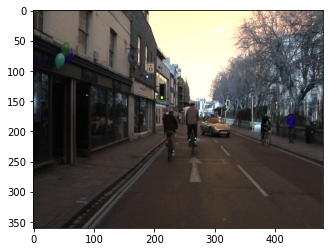

In [0]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread(predict_image_filepath)
plt.imshow(img.astype('uint8'))

We visualize the predicted output:

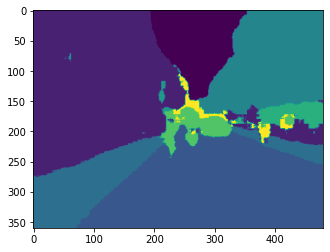

In [0]:
import matplotlib.pyplot as plt
plt.imshow(out)

We visualize the fused image (see the dataset section).

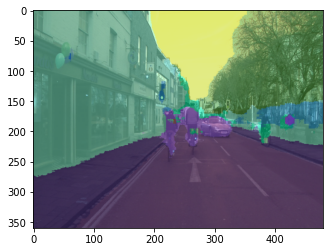

In [0]:
import cv2

inp_img = cv2.imread(predict_image_filepath)
out_img = cv2.imread("out.png")

from keras_segmentation.predict import overlay_seg_image
fused_img = overlay_seg_image(inp_img, out_img)

import matplotlib.pyplot as plt
plt.imshow(fused_img.astype('uint8'))